# 使用DNN进行文本分类

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gensim
import jieba

In [35]:
import pandas as pd

In [33]:
%matplotlib inline

## 读取文件中的训练集，验证集，测试集

In [3]:
# 读取训练集标签
train_label = np.loadtxt('./train_label_text.txt', delimiter=',', dtype=np.int16)
train_label_onehot = tf.one_hot(list(train_label), depth=10)

# 读取训练集特征
train_data_temp = []
train_data = []
with open('./train_data_text_clear.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        train_data_temp.append(line.strip().strip('[]').split(','))
for line in train_data_temp:
    new_line = []
    for word in line:
        word = word.strip().strip('\'')
        new_line.append(word)
    train_data.append(new_line)
del train_data_temp

In [4]:
# 读取验证集
valid_label = np.loadtxt('./valid_label_text.txt', delimiter=',', dtype=np.int16)
valid_label_onehot = tf.one_hot(list(valid_label), depth=10)

# 读取验证集特征
valid_data_temp = []
valid_data = []
with open('./valid_data_text.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        valid_data_temp.append(line.strip().strip('[]').split(','))
for line in valid_data_temp:
    new_line = []
    for word in line:
        word = word.strip().strip('\'')
        new_line.append(word)
    valid_data.append(new_line)
del valid_data_temp

In [45]:
# 读取测试集
test_label = np.loadtxt('./test_label_text.txt', delimiter=',')

# 读取测试集特征
test_data_temp = []
test_data = []
with open('./test_data_text.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        test_data_temp.append(line.strip().strip('[]').split(','))
for line in test_data_temp:
    new_line = []
    for word in line:
        word = word.strip().strip('\'')
        new_line.append(word)
    test_data.append(new_line)
del test_data_temp

## 读取word2vec模型和词典

In [6]:
# 读取词向量模型
# word2vec_model = gensim.models.word2vec.Word2Vec.load('./corpus/zhwiki.word2vec.model')
word2vec_model = gensim.models.word2vec.Word2Vec.load('./myNewsModel_pure')

In [7]:
# # 读取词典
# idx2word = np.load('./zhwiki.dict.npy', allow_pickle=True)
# idx2word = idx2word.item()

In [8]:
# # 读取word2idx
# word2idx = np.load('./zhwiki.dict.word2idx.npy', allow_pickle=True)
# word2idx = word2idx.item()

In [9]:
# # 添加词典项目
# idx2word[2032566] = '?'
# word2idx['?'] = 2032566

In [10]:
# 使用自己的词库
word_list = word2vec_model.wv.index2word

In [11]:
idx2word = {}
for i in range(word_list.__len__()):
    idx2word[i+2] = word_list[i]
idx2word[0] = ' '
idx2word[1] = '?'

In [12]:
word2idx = {word: idx for idx, word in idx2word.items()}

In [13]:
# 词条数目
numOfWord = len(word2idx)

In [14]:
# 词向量维度
wordvector_dim = len(word2vec_model.wv['大海'])
print(wordvector_dim)

100


In [15]:
fill_vector = np.zeros([wordvector_dim, ])

In [16]:
print(word2idx[' '])

0


In [17]:
# 词向量矩阵
embedding_mat = []
for i in range(numOfWord):
    try:
        embedding_mat.append(word2vec_model[idx2word[i]])
    except:
        embedding_mat.append(fill_vector)

D:\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [18]:
del word2vec_model

## 将词语转换为下标

In [19]:
# 句子的最大长度，超过截断，不足补零
max_len = 50

In [20]:
# 转换训练集
train_data_idx = []
for sentencen in train_data:
    temp = []
    for word in sentencen:
        if word in word2idx:
            temp_word = word2idx[word]
        else:
            temp_word = word2idx['?']
        temp.append(temp_word)
    train_data_idx.append(temp)

In [21]:
del train_data

In [22]:
# 转换验证集
valid_data_idx = []
for sentencen in valid_data:
    temp = []
    for word in sentencen:
        if word in word2idx:
            temp_word = word2idx[word]
        else:
            temp_word = word2idx['?']
        temp.append(temp_word)
    valid_data_idx.append(temp)

In [23]:
del valid_data

In [46]:
# 转换测试集
test_data_idx = []
for sentencen in test_data:
    temp = []
    for word in sentencen:
        if word in word2idx:
            temp_word = word2idx[word]
        else:
            temp_word = word2idx['?']
        temp.append(temp_word)
    test_data_idx.append(temp)

In [47]:
del test_data

## 数据整形

In [24]:
train_data_idx_matrix = keras.preprocessing.sequence.pad_sequences(train_data_idx, maxlen=max_len)
valid_data_idx_matrix = keras.preprocessing.sequence.pad_sequences(valid_data_idx, maxlen=max_len)

In [48]:
test_data_idx_matrix = keras.preprocessing.sequence.pad_sequences(test_data_idx, maxlen=max_len)

In [25]:
print(train_data_idx_matrix.shape)
print(valid_data_idx_matrix.shape)

(50000, 50)
(5000, 50)


In [50]:
print(test_data_idx_matrix.shape)

(10000, 50)


In [26]:
np_embedding_mat = np.array(embedding_mat)

In [27]:
np_embedding_mat[0].shape

(100,)

## 构建DNN模型

In [41]:
# 神经网络模型
model = keras.Sequential()

model.add(layers.Embedding(
    len(np_embedding_mat),
    wordvector_dim,
    weights = [np_embedding_mat],
    input_length = max_len,
    trainable = False
))

model.add(layers.LSTM(128, dropout = 0.2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [42]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=2, min_delta=1e-2)
]

# 编译模型
model.compile(
    loss = tf.losses.sparse_categorical_crossentropy,
    optimizer = 'adam',
    metrics = ['accuracy'],
    callbacks = callbacks
)

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           35770500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 35,905,550
Trainable params: 135,050
Non-trainable params: 35,770,500
____________________________________

In [44]:
history = model.fit(
    train_data_idx_matrix,
#     list(train_label_onehot),
    train_label,
    epochs = 10,
#     validation_data = [valid_data_idx_matrix, list(valid_label_onehot)]
    validation_data = [valid_data_idx_matrix, valid_label],
    batch_size = 500
)

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
50000/50000 [==============================] - 22s 449us/sample - loss: 0.9455 - accuracy: 0.7128 - val_loss: 0.6291 - val_accuracy: 0.8188
Epoch 2/10
50000/50000 [==============================] - 17s 331us/sample - loss: 0.4169 - accuracy: 0.8870 - val_loss: 0.6062 - val_accuracy: 0.8272
Epoch 3/10
50000/50000 [==============================] - 16s 330us/sample - loss: 0.3429 - accuracy: 0.9043 - val_loss: 0.5342 - val_accuracy: 0.8430
Epoch 4/10
50000/50000 [==============================] - 18s 350us/sample - loss: 0.3026 - accuracy: 0.9154 - val_loss: 0.6527 - val_accuracy: 0.8258
Epoch 5/10
50000/50000 [==============================] - 17s 332us/sample - loss: 0.2838 - accuracy: 0.9200 - val_loss: 0.5868 - val_accuracy: 0.8432
Epoch 6/10
50000/50000 [==============================] - 17s 331us/sample - loss: 0.2600 - accuracy: 0.9260 - val_loss: 0.5200 - val_accuracy: 0.8550
Epoch 7/10
50000/50000 [=====================

In [32]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

### **Model_1:** input -> embedding -> lstm -> output

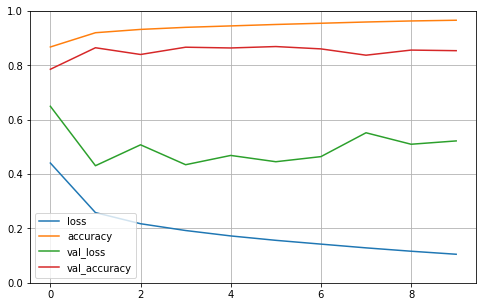

In [36]:
plot_learning_curves(history)

### **Model_2:** input -> embedding -> lstm -> dense -> dropout -> output

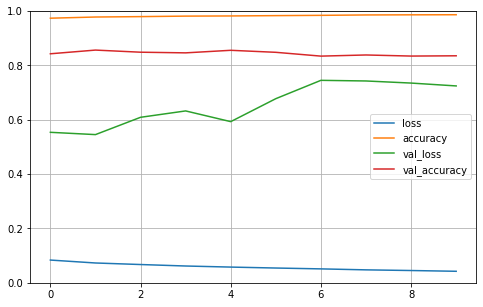

In [40]:
plot_learning_curves(history)

### **Model_3:** input -> embedding -> lstm -> dropout_1 -> dense_1 -> dropout_2 -> dense_2 -> dropout_3 -> output

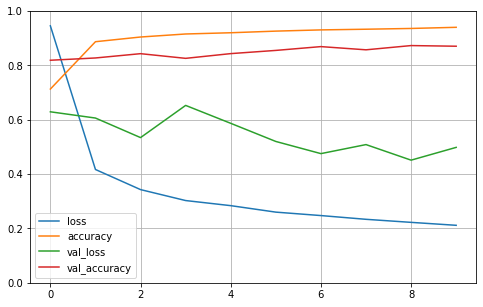

In [51]:
plot_learning_curves(history)

In [52]:
model.evaluate(test_data_idx_matrix, test_label)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.28700940292502053, 0.9177]